# Lotka-Volterra Model for Population Development
The Lotka-Volterra Model describes the population development of two species, the prey which are hunted by the predators.

In [1]:
# Because this very small model doesn't profit from parallelization on GPU's, it can be faster to run it on CPU instead.
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import jax.numpy as jnp
from jax import jit
from jax.flatten_util import ravel_pytree
import numpy as np
from adoptODE import train_adoptODE, simple_simulation
import matplotlib.pyplot as plt

#### Defining the equation of motion for Lotka Volterra dynamics
Here, we define the parameters as iparams (individual params) instead of params. That way, when multiple systems are simulated, each is fitted its own set of parameters instead of a universal set of parameters for all simulated systems. This is used to generate the statistics displayed in the article.
The pure sytem has for parameters, $\alpha,\beta,\gamma$ and $\delta$. Two additional terms with parameters $c_1$ and $c_2$ are added to the dynamics. For the creation of trajectories, these are always set to zero, but the recovery just knows them as regular parameters and has to figure out that the respectie terms are not contributing to the observed dynamics.

In [3]:
def define_LV(**kwargs_sys):
    N_sys = kwargs_sys['N_sys']
    @jit
    def eom(y, t, params, iparams, exparams):
        dprey = iparams['alpha']*y['prey'] - iparams['beta']*y['prey']*y['predators'] - iparams['cprey']*y['prey']**2 #The last terms here are added atop pure LV dynamics
        dpred = iparams['delta']*y['prey']*y['predators'] - iparams['gamma']*y['predators']- iparams['cpredators']*y['predators']**2
        return {'prey':dprey, 'predators':dpred}

    @jit
    def loss(ys, params, iparams, exparams, targets):
        flat_fit = ravel_pytree(ys)[0]
        flat_target = ravel_pytree(targets)[0]
        return jnp.nanmean((flat_fit-flat_target)**2)


    def gen_params(): # Generate parameters for simulating trajectories, hence the pure model without the added terms, therefore c_1 = c_2 = 0
        a = 0.1+0.9*np.random.rand(N_sys)
        b = 0.1+0.9*np.random.rand(N_sys)
        c = 0.1+0.9*np.random.rand(N_sys)
        d = 0.1+0.9*np.random.rand(N_sys)
        iparams = {'alpha':a, 'beta':b, 'gamma':c, 'delta':d, 'cprey':np.zeros(N_sys, dtype=float), 'cpredators':np.zeros(N_sys, dtype=float)}
        return {}, iparams, {}

    def gen_y0():
        prey = 0.1+0.9*np.random.rand()
        pred = 0.1+0.9*np.random.rand()
        return {'prey':prey, 'predators':pred}


    return eom, loss, gen_params, gen_y0, {}

In [4]:
# Setting up system and training properties
kwargs_sys = {'N_sys':1}
t_evals=jnp.linspace(0,40,200)
reset_every = 20
t_reset_idcs = tuple([reset_every*i for i in range(int(np.ceil((len(t_evals)-1)/reset_every)))])
iparams_guess = {'alpha':np.zeros(1), 'beta':np.zeros(1), 'gamma':np.zeros(1), 'delta':np.zeros(1), 'cprey':np.zeros(1), 'cpredators':np.zeros(1)}
lower_bound_ip = {'alpha':0., 'beta':0., 'gamma':0., 'delta':0., 'cprey':-jnp.inf, 'cpredators':-jnp.inf}
lower_bound_y0 = {'prey':0., 'predators':0.}
kwargs_adoptODE = {'epochs':4000, 
               'lr':0,
               'lr_ip':1e-2, 
               't_reset_idcs':t_reset_idcs, 
               'lr_y0':3e-3, 
               'lower_b_ip':lower_bound_ip, 
               'lower_b_y0':lower_bound_y0, 
               'lr_decay_ip':0.9994, 
               'lr_decay_y0':0.9994}

# Generating dataset via simulation
dataset = simple_simulation(define_LV, t_evals, kwargs_sys, kwargs_adoptODE, iparams_train=iparams_guess, rel_noise=0.01)

In [5]:
# Performing training
params_final, losses, errors, params_history = train_adoptODE(dataset)

Epoch 000:   Params Err.: 0.0e+00, y0 error: 1.7e-01, Params Norm: 0.0e+00, iParams Err.: 1.3e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.2e+02, 
Epoch 400:   Params Err.: 0.0e+00, y0 error: 8.2e-01, Params Norm: 0.0e+00, iParams Err.: 2.2e-01, iParams Norm: 1.1e+00, Stopped/Resetted Loss: 1.0e-01, 
Epoch 800:   Params Err.: 0.0e+00, y0 error: 6.1e-01, Params Norm: 0.0e+00, iParams Err.: 2.0e-01, iParams Norm: 1.1e+00, Stopped/Resetted Loss: 1.7e-02, 
Epoch 1200:   Params Err.: 0.0e+00, y0 error: 5.4e-01, Params Norm: 0.0e+00, iParams Err.: 1.8e-01, iParams Norm: 1.1e+00, Stopped/Resetted Loss: 2.4e-02, 
Epoch 1600:   Params Err.: 0.0e+00, y0 error: 5.3e-01, Params Norm: 0.0e+00, iParams Err.: 1.7e-01, iParams Norm: 1.2e+00, Stopped/Resetted Loss: 1.4e-02, 
Epoch 2000:   Params Err.: 0.0e+00, y0 error: 5.3e-01, Params Norm: 0.0e+00, iParams Err.: 1.5e-01, iParams Norm: 1.2e+00, Stopped/Resetted Loss: 1.7e-02, 
Epoch 2400:   Params Err.: 0.0e+00, y0 error: 5.3e-01, Params Norm:

In [6]:
print(*['{}: Truth: {:.5f}, Recov.: {:.5f} \n'.format(k, dataset.iparams[k][0], dataset.iparams_train[k][0]) for k in dataset.iparams.keys()])

alpha: Truth: 0.95539, Recov.: 0.85178 
 beta: Truth: 0.11483, Recov.: 0.11551 
 gamma: Truth: 0.73523, Recov.: 0.73911 
 delta: Truth: 0.39695, Recov.: 0.39517 
 cprey: Truth: 0.00000, Recov.: -0.01532 
 cpredators: Truth: 0.00000, Recov.: -0.00074 



#### Fitting multiple trajectories:

In [7]:
N_sys = 100 # This number of Systems is independently generated with random parameters, simulated and afterwards recovered
rel_noise_amplitude = 0.01
kwargs_sys = {'N_sys': N_sys}
kwargs_adoptODE = {'epochs':4000, # For better recovery 20000 epochs are necessary, increasing runtime
               'lr':0,
               'lr_ip':1e-2, 
               't_reset_idcs':t_reset_idcs, 
               'lr_y0':3e-3, 
               'lower_b_ip':lower_bound_ip, 
               'lower_b_y0':lower_bound_y0, 
               'lr_decay_ip':0.9996, 
               'lr_decay_y0':0.9996}
iparams_guess = {
    'alpha': np.zeros(N_sys),
    'beta': np.zeros(N_sys),
    'gamma': np.zeros(N_sys),
    'delta': np.zeros(N_sys),
    'cprey':np.zeros(N_sys),
    'cpredators':np.zeros(N_sys)  
}

dataset = simple_simulation(define_LV, t_evals, kwargs_sys, kwargs_adoptODE, iparams_train=iparams_guess, rel_noise=rel_noise_amplitude)

params_final, losses, errors, params_history = train_adoptODE(dataset)

Epoch 000:   Params Err.: 0.0e+00, y0 error: 6.9e-01, Params Norm: 0.0e+00, iParams Err.: 1.2e+01, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 8.1e+00, 
Epoch 400:   Params Err.: 0.0e+00, y0 error: 2.7e+00, Params Norm: 0.0e+00, iParams Err.: 1.4e+00, iParams Norm: 1.2e+01, Stopped/Resetted Loss: 5.7e-03, 
Epoch 800:   Params Err.: 0.0e+00, y0 error: 2.1e+00, Params Norm: 0.0e+00, iParams Err.: 1.1e+00, iParams Norm: 1.2e+01, Stopped/Resetted Loss: 4.5e-03, 
Epoch 1200:   Params Err.: 0.0e+00, y0 error: 1.8e+00, Params Norm: 0.0e+00, iParams Err.: 9.2e-01, iParams Norm: 1.2e+01, Stopped/Resetted Loss: 3.3e-03, 
Epoch 1600:   Params Err.: 0.0e+00, y0 error: 1.6e+00, Params Norm: 0.0e+00, iParams Err.: 8.1e-01, iParams Norm: 1.2e+01, Stopped/Resetted Loss: 2.2e-03, 
Epoch 2000:   Params Err.: 0.0e+00, y0 error: 1.4e+00, Params Norm: 0.0e+00, iParams Err.: 7.2e-01, iParams Norm: 1.2e+01, Stopped/Resetted Loss: 1.9e-03, 
Epoch 2400:   Params Err.: 0.0e+00, y0 error: 1.3e+00, Params Norm:

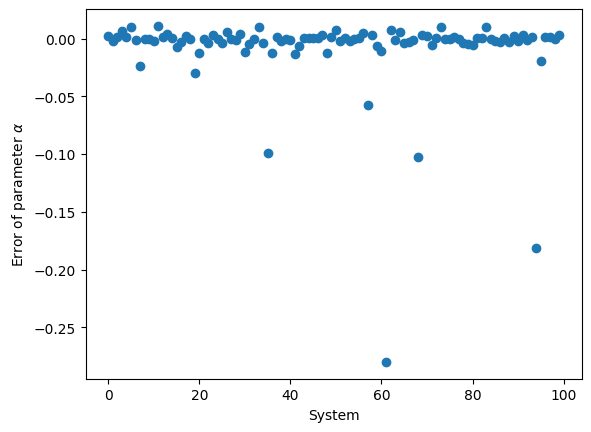

In [8]:
# Plot the error of recovered parameter alpha for the simulated systems
plt.scatter(np.arange(len(dataset.iparams_train['alpha'])), dataset.iparams_train['alpha']-dataset.iparams['alpha'])
plt.xlabel('System')
plt.ylabel('Error of parameter $\\alpha$')
plt.show()

#### Example of using ODE Solvers from [Diffrax](https://github.com/patrick-kidger/diffrax):

For this diffrax needs to be installed: 

pip install diffrax

In [11]:
import diffrax

def custom_ode_solver(eom, y0, t, *args, rtol=1.4e-8, atol=1.4e-8, mxstep=jnp.inf, dt_ini=0.01):
    func = lambda y,t,args: eom(t,y,*args) # Diffrax expexts other structure of arguments
    sol = diffrax.diffeqsolve(diffrax.ODETerm(func),
                               diffrax.Tsit5(),
                                t[0],
                                t[-1],
                                0.01,
                                y0,
                                args,
                                saveat=diffrax.SaveAt(ts=t),
                                stepsize_controller=diffrax.PIDController(pcoeff=0.4, icoeff=0.3, dcoeff=0, rtol=rtol,atol=atol),
                                max_steps=100000)
    return sol.ys

In [12]:
# Setting up system and training properties
kwargs_sys = {'N_sys':1}
t_evals=jnp.linspace(0,40,200)
reset_every = 20
t_reset_idcs = tuple([reset_every*i for i in range(int(np.ceil((len(t_evals)-1)/reset_every)))])
iparams_guess = {'alpha':np.zeros(1), 'beta':np.zeros(1), 'gamma':np.zeros(1), 'delta':np.zeros(1), 'cprey':np.zeros(1), 'cpredators':np.zeros(1)}
lower_bound_ip = {'alpha':0., 'beta':0., 'gamma':0., 'delta':0., 'cprey':-jnp.inf, 'cpredators':-jnp.inf}
lower_bound_y0 = {'prey':0., 'predators':0.}
kwargs_adoptODE = {'epochs':4000, 
               'lr':0,
               'lr_ip':1e-2, 
               't_reset_idcs':t_reset_idcs, 
               'lr_y0':3e-3, 
               'lower_b_ip':lower_bound_ip, 
               'lower_b_y0':lower_bound_y0, 
               'lr_decay_ip':0.9994, 
               'lr_decay_y0':0.9994,
               'ODE_solver':custom_ode_solver} # Pass custom ODE solver fitted to work as Jax's odeint here!

# Generating dataset via simulation
dataset = simple_simulation(define_LV, t_evals, kwargs_sys, kwargs_adoptODE, iparams_train=iparams_guess, rel_noise=0.01)

In [13]:
# Performing training
params_final, losses, errors, params_history = train_adoptODE(dataset)

Epoch 000:   Params Err.: 0.0e+00, y0 error: 2.6e-02, Params Norm: 0.0e+00, iParams Err.: 1.3e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 7.2e-01, 
Epoch 400:   Params Err.: 0.0e+00, y0 error: 1.4e-02, Params Norm: 0.0e+00, iParams Err.: 3.2e-03, iParams Norm: 1.3e+00, Stopped/Resetted Loss: 7.2e-05, 
Epoch 800:   Params Err.: 0.0e+00, y0 error: 1.5e-02, Params Norm: 0.0e+00, iParams Err.: 2.5e-03, iParams Norm: 1.3e+00, Stopped/Resetted Loss: 1.1e-04, 
Epoch 1200:   Params Err.: 0.0e+00, y0 error: 1.5e-02, Params Norm: 0.0e+00, iParams Err.: 2.3e-03, iParams Norm: 1.3e+00, Stopped/Resetted Loss: 9.1e-05, 
Epoch 1600:   Params Err.: 0.0e+00, y0 error: 1.4e-02, Params Norm: 0.0e+00, iParams Err.: 2.1e-03, iParams Norm: 1.3e+00, Stopped/Resetted Loss: 5.2e-05, 
Epoch 2000:   Params Err.: 0.0e+00, y0 error: 1.4e-02, Params Norm: 0.0e+00, iParams Err.: 2.2e-03, iParams Norm: 1.3e+00, Stopped/Resetted Loss: 5.4e-05, 
Epoch 2400:   Params Err.: 0.0e+00, y0 error: 1.4e-02, Params Norm:

In [14]:
print(*['{}: Truth: {:.5f}, Recov.: {:.5f} \n'.format(k, dataset.iparams[k][0], dataset.iparams_train[k][0]) for k in dataset.iparams.keys()])

alpha: Truth: 0.65268, Recov.: 0.65217 
 beta: Truth: 0.68587, Recov.: 0.68534 
 gamma: Truth: 0.46759, Recov.: 0.46857 
 delta: Truth: 0.67677, Recov.: 0.67683 
 cprey: Truth: 0.00000, Recov.: 0.00135 
 cpredators: Truth: 0.00000, Recov.: -0.00093 

